In [1]:
#Saving and Loading of Models in PyTorch
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper
import fc_model

In [5]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=False, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=False, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

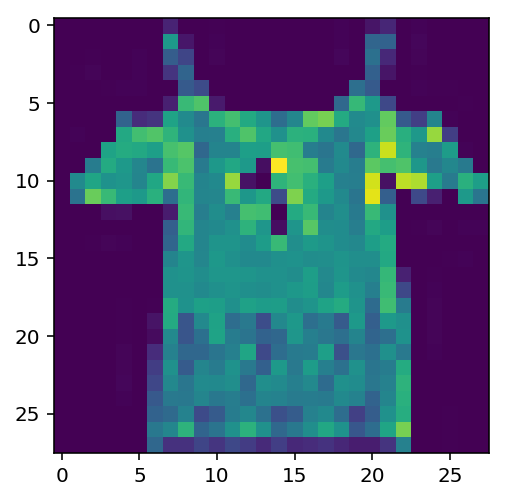

In [7]:
image,label = next(iter(trainloader))
plt.imshow(image[0].numpy().squeeze())

In [30]:
model = nn.Sequential(
                    nn.Linear(784,256),
                    nn.ReLU(),
                    nn.Linear(256,128),
                    nn.ReLU(),
                    nn.Linear(128,64),
                    nn.ReLU(),
                    nn.Linear(64,10),
                    nn.LogSoftmax(dim=1)
)
#defining the loss
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr=0.003)

In [31]:
#trainig the model
epochs = 5
steps = 0
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images,labels in trainloader:
        optimizer.zero_grad()
        images = images.view(images.shape[0],-1)
        log_ps = model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    else:
        test_loss = 0
        accuracy = 0
        #turning off the gradients will save memory and time
        with torch.no_grad():
            for images,labels in testloader:
                images = images.view(images.shape[0],-1)
                log_ps = model(images)
                test_loss += criterion(log_ps,labels)
                
                ps = torch.exp(log_ps)
                top_p,top_class = ps.topk(1,dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/5..  Training Loss: 0.517..  Test Loss: 0.454..  Test Accuracy: 0.833
Epoch: 2/5..  Training Loss: 0.393..  Test Loss: 0.418..  Test Accuracy: 0.853
Epoch: 3/5..  Training Loss: 0.356..  Test Loss: 0.384..  Test Accuracy: 0.863
Epoch: 4/5..  Training Loss: 0.331..  Test Loss: 0.392..  Test Accuracy: 0.862
Epoch: 5/5..  Training Loss: 0.317..  Test Loss: 0.390..  Test Accuracy: 0.857


In [32]:
#we can use the state.dict keys 
#to save the model
print("The state dict keys",model.state_dict().keys())

The state dict keys odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias', '6.weight', '6.bias'])


In [33]:
#we can save the state_dict torch.save
torch.save(model.state_dict(),'checkpoint.pth')

In [34]:
#we can load our state dict with torch.load
state_dict_a = torch.load('checkpoint.pth')
print(state_dict_a.keys())

odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias', '6.weight', '6.bias'])


In [35]:
#this thing only works if the model architucture is same as the one in the state_dict
model.load_state_dict(state_dict_a)
hidden_layers=[]
for each in model:
    #print(each)
    try:
        a=each.out_features
        hidden_layers.append(a)
    except:
        #print("--------------------")
        b = 1+1

In [36]:
#so it is useful to save the info of model ie architucture in the state dict too
checkpoint = {
    'input_size':784,
    'output_size':10,
    'hidden_layers':hidden_layers,
    'state_dict':model.state_dict()
}
torch.save(checkpoint,'checkpoint_a.pth')

In [37]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model